In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pathlib
import tqdm
from matplotlib import pyplot as plt
from statistics import *


import math
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
f
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

import warnings

# Confidence intervals Method

- Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
- Second one is constant variance. It looks like constant. (yes stationary)
- The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

In [27]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

we will assume that the future value of our variable depends on the average of its  k  previous values. Therefore, we will use the moving average.

y^t=1k∑n=1kyt−n

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [28]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ts, 24) # prediction for the last observed day (past 24 hours)

50.912519083333336

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe ads_anomaly.

Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

y^t=∑n=1kωnyt+1−n

In [29]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(18,3))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

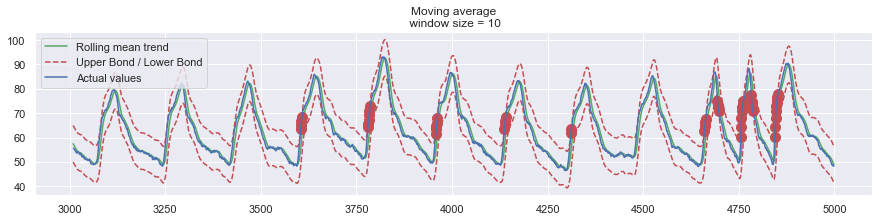

In [30]:
plotMovingAverage(ts[3000:5000], 10, plot_intervals=True, plot_anomalies=True)

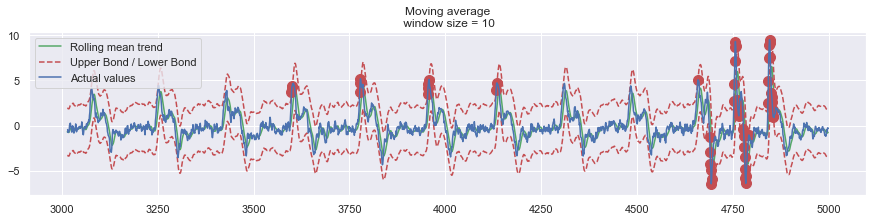

In [31]:
plotMovingAverage(ts_moving_avg_diff[3000:5000], 10, plot_intervals=True, plot_anomalies=True)

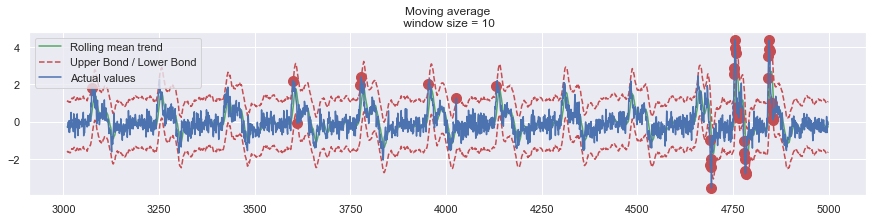

In [32]:
plotMovingAverage(ts_diff[3000:5000], 10, plot_intervals=True, plot_anomalies=True)

# PyCaret Method

In [1]:
#dff = pd.read_csv('./df_iforest.csv')
#dff[['data_id','Method','anomaly_start','anomaly_end','Top 30 results','Result','Rank']].head(25)

In [3]:
#dff[dff['Result']==True][['data_id','Method','Rank']].groupby(['data_id']).min()

In [4]:
# init setup
#from pycaret.anomaly import *
#s = setup(ts,silent=True)

In [5]:
#models()

In [78]:
# init setup
from pycaret.anomaly import *

# Path
path = pathlib.Path('./phase_2') / 'phase_2' 
df_ts_diff = pd.DataFrame(columns=['data_id','Method'])
results = pd.read_csv('./metadata.csv')
file=0
for path in sorted(path.iterdir()):
    file=file+1
    data = np.loadtxt(path)
    df_data = pd.DataFrame (data, columns = ['column_name'])
    number = path.stem.split('_')[0]
    EndOfTrainingIndex = int(path.stem.split('_')[-1])
    id = int(path.stem.split('_')[0])

    moving_avg = df_data.rolling(window_size).mean()
    ts_moving_avg_diff = df_data- moving_avg
    ts_moving_avg_diff.dropna(inplace=True)
    
   # ts_diff = df_data - df_data.shift()
   # ts_diff.dropna(inplace=True) 

    
    # Setup
    s = setup(ts_moving_avg_diff[EndOfTrainingIndex:],silent=True)
    if (file<150):
        mod=['abod', 'cluster',  'iforest', 'histogram', 'knn']
    else:
        mod=['cluster',  'iforest', 'histogram']
    # train models
    for i in mod :
        model=i
        model_pycaret = create_model(model, fraction = 0.1)
        model_results = assign_model(model_pycaret)
        top30_model_results=list(model_results[model_results['Anomaly'] == 1].sort_values(by=['Anomaly_Score'], ascending=False).head(20).index)
        df_ts_diff = df_ts_diff.append({'Method':model,'data_id':id,'Length':len(data),'End Index':EndOfTrainingIndex,'Top 30 results':top30_model_results,'Top anomaly scores':list(model_results[model_results['Anomaly'] == 1])},ignore_index=True)
    

    

In [79]:
df_ts_diff

,data_id,Method,End Index,Length,Top 30 results,Top anomaly scores
0,1,abod,35000.0,79795.0,"[67315, 39562, 69221, 66399, 67090, 67089, 457...","[column_name, Anomaly, Anomaly_Score]"
1,1,cluster,35000.0,79795.0,"[39562, 66631, 76765, 66864, 49998, 49544, 454...","[column_name, Anomaly, Anomaly_Score]"
2,1,iforest,35000.0,79795.0,"[45042, 39562, 66864, 49998, 71184, 45496, 763...","[column_name, Anomaly, Anomaly_Score]"
3,1,histogram,35000.0,79795.0,"[55960, 76535, 75845, 55957, 45498, 66633, 758...","[column_name, Anomaly, Anomaly_Score]"
4,1,knn,35000.0,79795.0,"[67315, 69221, 39562, 66399, 39333, 75845, 614...","[column_name, Anomaly, Anomaly_Score]"
...,...,...,...,...,...,...
893,247,iforest,50211.0,200000.0,"[106617, 106367, 106619, 106868, 106618, 10711...","[column_name, Anomaly, Anomaly_Score]"
894,247,histogram,50211.0,200000.0,"[107118, 106369, 106120, 106619, 107018, 10651...","[column_name, Anomaly, Anomaly_Score]"
895,250,cluster,2951.0,10468.0,"[5966, 8082, 7295, 7302, 8549, 4326, 6436, 784...","[column_name, Anomaly, Anomaly_Score]"
896,250,iforest,2951.0,10468.0,"[9412, 8545, 4322, 10186, 6432, 8078, 5962, 38...","[column_name, Anomaly, Anomaly_Score]"


In [80]:
test=pd.merge(results, df_ts_diff, on='data_id')
test['Result']=False
test['Rank']=1000
for j in range(len(test)):
    for i in range(len(test['Top 30 results'][j])): 
        if test['Top 30 results'][j][i] >= test['anomaly_start'][j] and test['Top 30 results'][j][i] <= test['anomaly_end'][j] :
            test['Result'][j]=True
            test['Rank'][j]=i
            break  


In [81]:
test[['data_id','Method','anomaly_start','anomaly_end','Top 30 results','Result','Rank']].head(25)

,data_id,Method,anomaly_start,anomaly_end,Top 30 results,Result,Rank
0,1,abod,52000,52620,"[67315, 39562, 69221, 66399, 67090, 67089, 457...",False,1000
1,1,cluster,52000,52620,"[39562, 66631, 76765, 66864, 49998, 49544, 454...",False,1000
2,1,iforest,52000,52620,"[45042, 39562, 66864, 49998, 71184, 45496, 763...",False,1000
3,1,histogram,52000,52620,"[55960, 76535, 75845, 55957, 45498, 66633, 758...",False,1000
4,1,knn,52000,52620,"[67315, 69221, 39562, 66399, 39333, 75845, 614...",False,1000
5,2,abod,56600,56900,"[67521, 39562, 69427, 66605, 45734, 69431, 619...",True,15
6,2,cluster,56600,56900,"[39562, 76971, 66837, 49998, 67294, 45042, 495...",False,1000
7,2,iforest,56600,56900,"[49544, 67070, 45042, 45272, 76971, 49998, 619...",False,1000
8,2,histogram,56600,56900,"[76741, 67293, 67296, 45044, 49997, 76048, 395...",True,9
9,2,knn,56600,56900,"[67521, 69427, 66605, 39562, 67296, 67295, 666...",True,8


In [85]:
test[test['Result']==True][['data_id','Method','Rank']].groupby(['data_id']).min()


,Method,Rank
data_id,,
2,abod,8
4,abod,3
8,abod,0
10,abod,0
11,abod,0
...,...,...
230,cluster,7
235,cluster,0
237,iforest,13


In [83]:
test[test['Rank']==0][['data_id','Method','Rank']].groupby(['data_id']).min()

,Method,Rank
data_id,,
8,abod,0
10,abod,0
11,abod,0
12,abod,0
16,abod,0
...,...,...
209,iforest,0
213,cluster,0
216,cluster,0


In [84]:
#test.to_csv(r'.\df_pycaret_OriginalData.csv')

In [86]:
test.to_csv(r'.\df_pycaret_moving_avg_diff_phase2.csv')

In [73]:
test.to_csv(r'.\df__df_ts_diff_phase2.csv')

## Evaluation

In [39]:
dfnotnull = test[test['Top 30 results'].str.len() != 0]
dfnotnull.reset_index(drop=True, inplace=True)

In [40]:
def cluster(data, maxgap):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap=200*
    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    
    return groups

In [41]:
from statistics import *
import statistics

g=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
dfnotnull['Clusters']=''
dfnotnull['Meds']=''
dfnotnull['Med']=0
dfnotnull['AVG']=''
dfnotnull['AVG_estimation']=''


for j in range(len(dfnotnull)):
    cl=cluster(dfnotnull['Top 30 results'][j], 500)
    print('clusters',j ,cl)
    dfnotnull['Clusters'][j]=cl
    dfnotnull['AVG'][j]=[sum(sub_list) / len(sub_list) for sub_list in cl]
    dfnotnull['AVG_estimation'][j]=statistics.mean(dfnotnull['AVG'][j])
    
    
    for i in range(len(cl)):
        print(i,len(cl[i]),median(cl[i]))
        g[i]=[len(cl[i]),median(cl[i])]
        print(len(cl[i]),median(cl[i]))
        dfnotnull['Med'][j]+=g[i][0]*g[i][1]

    dfnotnull['Meds'][j]=g
    print(g)
    print(dfnotnull['Med'][j])
    dfnotnull['Med'][j]=dfnotnull['Med'][j]/len(dfnotnull['Top 30 results'][j])
    print('woo', len(dfnotnull['Top 30 results'][j]),dfnotnull['Med'][j])
   
        

clusters 0 [[45042, 45496, 45499], [49544, 49546], [66888, 66889, 66892, 66893], [69445, 69452, 69667, 69668, 69669, 69670], [70960, 71185, 71186, 71191], [76075]]
0 3 45496
3 45496
1 2 49545.0
2 49545.0
2 4 66890.5
4 66890.5
3 6 69667.5
6 69667.5
4 4 71185.5
4 71185.5
5 1 76075
1 76075
[[3, 45496], [2, 49545.0], [4, 66890.5], [6, 69667.5], [4, 71185.5], [1, 76075], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1281962
woo 20 64098
clusters 1 [[39798], [45042, 45043, 45272, 45496], [49544, 49545, 49999], [61490, 61491], [70960, 70961, 70962, 71184, 71185, 71186, 71187], [75843, 75844], [76765]]
0 1 39798
1 39798
1 4 45157.5
4 45157.5
2 3 49545
3 49545
3 2 61490.5
2 61490.5
4 7 71184
7 71184
5 2 75843.5
2 75843.5
6 1 76765
1 76765
[[1, 39798], [4, 45157.5], [3, 49545], [2, 61490.5], [7, 71184], [2, 75843.5], [1, 76765], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1218784
woo 20 60939
clusters 2 [[39798], [45042, 45272], [49544, 49

woo 20 20031
clusters 43 [[15656, 15657, 15658, 15659, 15660, 16055, 16056], [17848, 17849, 17850], [22827, 22828, 22829, 22830, 22831, 22832], [25820, 25821, 25822, 25823]]
0 7 15659
7 15659
1 3 17849
3 17849
2 6 22829.5
6 22829.5
3 4 25821.5
4 25821.5
[[7, 15659], [3, 17849], [6, 22829.5], [4, 25821.5], [1, 23418], [1, 24541], [2, 25822.0], [1, 25822], [1, 26991], [1, 24541], [2, 27179.0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
403423
woo 20 20171
clusters 44 [[15652, 15656, 15659, 15660, 16054, 16055, 16056], [17846, 17847, 17850, 17851], [21537], [22825, 22826, 22827, 22830, 22831], [25820, 25822], [26991]]
0 7 15660
7 15660
1 4 17848.5
4 17848.5
2 1 21537
1 21537
3 5 22827
5 22827
4 2 25821.0
2 25821.0
5 1 26991
1 26991
[[7, 15660], [4, 17848.5], [1, 21537], [5, 22827], [2, 25821.0], [1, 26991], [2, 25822.0], [1, 25822], [1, 26991], [1, 24541], [2, 27179.0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
395319
woo 20 19765
clusters 45 [[15364, 15

5 15692
2 1 19366
1 19366
3 2 22781.0
2 22781.0
4 1 25813
1 25813
5 3 27957
3 27957
6 1 29288
1 29288
[[7, 10607], [5, 15692], [1, 19366], [2, 22781.0], [1, 25813], [3, 27957], [1, 29288], [1, 23850], [1, 24500], [1, 28292], [1, 28292], [2, 28373.0], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
356609
woo 20 17830
clusters 69 [[8116], [11600, 11809], [12581, 12582, 12583], [13560], [14597, 14598], [15906], [16696, 16862, 17018, 17019], [18917], [21543], [23355, 23850], [24500], [28292]]
0 1 8116
1 8116
1 2 11704.5
2 11704.5
2 3 12582
3 12582
3 1 13560
1 13560
4 2 14597.5
2 14597.5
5 1 15906
1 15906
6 4 16940.0
4 16940.0
7 1 18917
1 18917
8 1 21543
1 21543
9 2 23602.5
2 23602.5
10 1 24500
1 24500
11 1 28292
1 28292
[[1, 8116], [2, 11704.5], [3, 12582], [1, 13560], [2, 14597.5], [1, 15906], [4, 16940.0], [1, 18917], [1, 21543], [2, 23602.5], [1, 24500], [1, 28292], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
336149
woo 20 16807

2 2880.5
1 15 4159
15 4159
2 3 7273
3 7273
[[2, 2880.5], [15, 4159], [3, 7273], [5, 7267], [5, 7456], [1, 7270], [1, 11592], [1, 18917], [1, 21543], [2, 23602.5], [1, 24500], [1, 28292], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
89965
woo 20 4498
clusters 112 [[2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463], [3202, 3203], [7024, 7027, 7028, 7029, 7030, 7032, 7033]]
0 11 2458
11 2458
1 2 3202.5
2 3202.5
2 7 7029
7 7029
[[11, 2458], [2, 3202.5], [7, 7029], [5, 7267], [5, 7456], [1, 7270], [1, 11592], [1, 18917], [1, 21543], [2, 23602.5], [1, 24500], [1, 28292], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
82646
woo 20 4132
clusters 113 [[3070], [3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797], [5069, 5070], [6358, 6359, 6360, 6361, 6362, 6363]]
0 1 3070
1 3070
1 11 3792
11 3792
2 2 5069.5
2 5069.5
3 6 6360.5
6 6360.5
[[1, 3070], [11, 3792], [2, 5069.5], [6, 6360.5], [5, 7456], [1, 7270], [

3 6625
2 2 7636.5
2 7636.5
3 1 11822
1 11822
4 1 12387
1 12387
5 3 13134
3 13134
6 1 15612
1 15612
7 1 18527
1 18527
8 1 20585
1 20585
9 1 23358
1 23358
10 2 27241.5
2 27241.5
[[4, 5304.0], [3, 6625], [2, 7636.5], [1, 11822], [1, 12387], [3, 13134], [1, 15612], [1, 18527], [1, 20585], [1, 23358], [2, 27241.5], [1, 28292], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
252540
woo 20 12627
clusters 158 [[5422, 5423], [6098], [6909, 7052], [16226], [18823, 18858], [20219, 20552, 20554, 20585, 20587], [23358, 23360, 23510, 23731, 24144, 24465], [26659]]
0 2 5422.5
2 5422.5
1 1 6098
1 6098
2 2 6980.5
2 6980.5
3 1 16226
1 16226
4 2 18840.5
2 18840.5
5 5 20554
5 20554
6 6 23620.5
6 23620.5
7 1 26659
1 26659
[[2, 5422.5], [1, 6098], [2, 6980.5], [1, 16226], [2, 18840.5], [5, 20554], [6, 23620.5], [1, 26659], [1, 20585], [1, 23358], [2, 27241.5], [1, 28292], [1, 28959], [1, 29627], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
355963
woo 20 17798
clusters 159 [[

1 4 13043.5
4 13043.5
2 1 14128
1 14128
3 2 16393.5
2 16393.5
4 2 18601.5
2 18601.5
5 1 19750
1 19750
6 2 20652.5
2 20652.5
7 1 24442
1 24442
8 1 25508
1 25508
9 3 27150
3 27150
10 1 29581
1 29581
[[2, 7545.5], [4, 13043.5], [1, 14128], [2, 16393.5], [2, 18601.5], [1, 19750], [2, 20652.5], [1, 24442], [1, 25508], [3, 27150], [1, 29581], [1, 27915], [1, 28758], [1, 29581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
373419
woo 20 18670
clusters 180 [[14479], [15538], [16103, 16104], [16702], [17255], [17764], [19306, 19384, 19385, 19386], [20253, 20254], [21000], [21772, 21773], [23254], [24496, 24643, 24645]]
0 1 14479
1 14479
1 1 15538
1 15538
2 2 16103.5
2 16103.5
3 1 16702
1 16702
4 1 17255
1 17255
5 1 17764
1 17764
6 4 19384.5
4 19384.5
7 2 20253.5
2 20253.5
8 1 21000
1 21000
9 2 21772.5
2 21772.5
10 1 23254
1 23254
11 3 24643
3 24643
[[1, 14479], [1, 15538], [2, 16103.5], [1, 16702], [1, 17255], [1, 17764], [4, 19384.5], [2, 20253.5], [1, 21000], [2, 21772.5], [1, 23254], [

0 8 5986.0
8 5986.0
1 5 8450
5 8450
2 7 10011
7 10011
[[8, 5986.0], [5, 8450], [7, 10011], [8, 8298.0], [3, 9608], [2, 9624.5], [3, 10512], [1, 20253], [1, 20999], [1, 21773], [3, 24643], [3, 24643], [1, 28758], [1, 29581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
160215
woo 20 8010
clusters 221 [[3713, 3810, 3909, 3926, 4204, 4319, 4597, 5090], [5973], [6759, 6857], [7745, 7942, 8236], [9024, 9318, 9612, 10107], [11186, 11303]]
0 8 4065.0
8 4065.0
1 1 5973
1 5973
2 2 6808.0
2 6808.0
3 3 7942
3 7942
4 4 9465.0
4 9465.0
5 2 11244.5
2 11244.5
[[8, 4065.0], [1, 5973], [2, 6808.0], [3, 7942], [4, 9465.0], [2, 11244.5], [3, 10512], [1, 20253], [1, 20999], [1, 21773], [3, 24643], [3, 24643], [1, 28758], [1, 29581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
136284
woo 20 6814
clusters 222 [[5832, 5833, 5834, 5835, 6135, 6136, 6379, 6380, 6536, 6537, 6538, 6539], [7265, 7266], [8053, 8054], [8742], [9624, 9626, 9627]]
0 12 6257.5
12 6257.5
1 2 7265.5
2 7265.5
2 2 8053.5
2 80

1 12983
2 1 13905
1 13905
3 1 18800
1 18800
4 1 20995
1 20995
5 2 23719.5
2 23719.5
6 1 24614
1 24614
7 1 26200
1 26200
8 2 26985.0
2 26985.0
9 1 28002
1 28002
10 1 28876
1 28876
11 1 30482
1 30482
12 1 31260
1 31260
13 1 34268
1 34268
14 2 35262.5
2 35262.5
15 1 38187
1 38187
[[2, 11933.5], [1, 12983], [1, 13905], [1, 18800], [1, 20995], [2, 23719.5], [1, 24614], [1, 26200], [2, 26985.0], [1, 28002], [1, 28876], [1, 30482], [1, 31260], [1, 34268], [2, 35262.5], [1, 38187], [2, 38088.5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
504373
woo 20 25218
clusters 246 [[15856, 15857], [17736], [19727], [23723, 23724], [26198], [28001, 28002], [28881], [33107, 33108, 33109], [34267, 34268], [35261, 35262, 35263], [38186, 38187]]
0 2 15856.5
2 15856.5
1 1 17736
1 17736
2 1 19727
1 19727
3 2 23723.5
2 23723.5
4 1 26198
1 26198
5 2 28001.5
2 28001.5
6 1 28881
1 28881
7 3 33108
3 33108
8 2 34267.5
2 34267.5
9 3 35262
3 35262
10 2 38186.5
2 38186.5
[[2, 15856.5], [1, 17736], [1, 19727], [2, 23723.5

3 7417
3 1 8048
1 8048
4 5 9051
5 9051
[[1, 5494], [10, 6334.5], [3, 7417], [1, 8048], [5, 9051], [4, 9051.5], [2, 46264.5], [1, 47878], [2, 49104.5], [1, 52459], [2, 53241.0], [1, 57125], [2, 62466.0], [1, 63639], [1, 57002], [1, 58005], [1, 58636], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
144393
woo 20 7219
clusters 275 [[4417, 4500, 4745], [5541], [6171, 6358, 6360], [7285, 7286, 7287, 7288, 7430, 7610, 8048], [8960, 9081], [9657, 9671, 9869, 9960]]
0 3 4500
3 4500
1 1 5541
1 5541
2 3 6358
3 6358
3 7 7288
7 7288
4 2 9020.5
2 9020.5
5 4 9770.0
4 9770.0
[[3, 4500], [1, 5541], [3, 6358], [7, 7288], [2, 9020.5], [4, 9770.0], [2, 46264.5], [1, 47878], [2, 49104.5], [1, 52459], [2, 53241.0], [1, 57125], [2, 62466.0], [1, 63639], [1, 57002], [1, 58005], [1, 58636], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
146252
woo 20 7312
clusters 276 [[3477, 3674], [4417], [5387, 5803, 6171, 6293, 6423, 6643, 6722, 6851], [7993, 8258, 8641, 8657, 8683, 9063, 9143, 9552, 10008]]
0 2 3

8 2 23523.0
2 23523.0
[[2, 4326.5], [1, 5062], [1, 14008], [2, 17706.5], [1, 18279], [2, 19103.5], [4, 22010.5], [5, 22826], [2, 23523.0], [1, 26279], [1, 26279], [1, 28319], [1, 82164], [1, 85592], [1, 50623], [3, 52939], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
368840
woo 20 18442
clusters 308 [[4326, 4327, 4510], [5062], [7714], [17707], [19012, 19195], [21257, 21634, 22010, 22011, 22012], [22624, 22827, 22828, 23028], [23620], [25262], [26279]]
0 3 4327
3 4327
1 1 5062
1 5062
2 1 7714
1 7714
3 1 17707
1 17707
4 2 19103.5
2 19103.5
5 5 22010
5 22010
6 4 22827.5
4 22827.5
7 1 23620
1 23620
8 1 25262
1 25262
9 1 26279
1 26279
[[3, 4327], [1, 5062], [1, 7714], [1, 17707], [2, 19103.5], [5, 22010], [4, 22827.5], [1, 23620], [1, 25262], [1, 26279], [1, 26279], [1, 28319], [1, 82164], [1, 85592], [1, 50623], [3, 52939], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
358192
woo 20 17909
clusters 309 [[4326, 4327], [6179], [7149], [9008], [9931], [16948

1 1 19990
1 19990
2 1 21461
1 21461
3 1 25835
1 25835
4 1 30382
1 30382
5 4 35712.0
4 35712.0
6 1 37986
1 37986
[[11, 13570], [1, 19990], [1, 21461], [1, 25835], [1, 30382], [4, 35712.0], [1, 37986], [1, 27462], [1, 28461], [1, 29363], [1, 31175], [1, 32182], [1, 34058], [1, 35050], [3, 37662], [2, 37661.5], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
427772
woo 20 21388
clusters 349 [[10684], [11872, 12286, 12600, 12707, 13034, 13462, 13463, 13570, 13675, 13676, 13781, 13886, 13991, 14096], [16799, 17034], [35816, 35817], [37661]]
0 1 10684
1 10684
1 14 13516.5
14 13516.5
2 2 16916.5
2 16916.5
3 2 35816.5
2 35816.5
4 1 37661
1 37661
[[1, 10684], [14, 13516.5], [2, 16916.5], [2, 35816.5], [1, 37661], [4, 35712.0], [1, 37986], [1, 27462], [1, 28461], [1, 29363], [1, 31175], [1, 32182], [1, 34058], [1, 35050], [3, 37662], [2, 37661.5], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
343042
woo 20 17152
clusters 350 [[47641, 47653, 47657, 47659, 47660, 47

12 10508.5
4 2 11700.0
2 11700.0
[[1, 6130], [1, 8749], [4, 9624.5], [12, 10508.5], [2, 11700.0], [1, 11110], [3, 12298], [1, 12908], [7, 17025], [1, 26478], [2, 28291.5], [1, 32182], [1, 34058], [1, 35050], [3, 37662], [2, 37661.5], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
202879
woo 20 10143
clusters 383 [[5481, 5486], [6136], [8094, 8314, 8531, 8532, 8534], [9185, 9187, 9188, 9192], [10504, 10938, 10941, 10942, 10943, 10944, 10945, 10946]]
0 2 5483.5
2 5483.5
1 1 6136
1 6136
2 5 8531
5 8531
3 4 9187.5
4 9187.5
4 8 10942.5
8 10942.5
[[2, 5483.5], [1, 6136], [5, 8531], [4, 9187.5], [8, 10942.5], [1, 11110], [3, 12298], [1, 12908], [7, 17025], [1, 26478], [2, 28291.5], [1, 32182], [1, 34058], [1, 35050], [3, 37662], [2, 37661.5], [1, 53580], [1, 64246], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
184048
woo 20 9202
clusters 384 [[6084, 6520], [8027], [8925, 8928], [9623, 9626, 9629, 9797], [10502, 10503, 10504, 10505, 10506, 10507, 10510, 10941, 10942], [11593, 11807]]

0 1 18808
1 18808
1 4 21065.5
4 21065.5
2 1 25564
1 25564
3 1 28738
1 28738
4 2 31265.0
2 31265.0
5 1 33061
1 33061
6 1 38312
1 38312
7 1 46293
1 46293
8 2 48809.5
2 48809.5
9 2 55947.0
2 55947.0
10 1 59155
1 59155
11 2 60290.5
2 60290.5
12 1 63409
1 63409
[[1, 18808], [4, 21065.5], [1, 25564], [1, 28738], [2, 31265.0], [1, 33061], [1, 38312], [1, 46293], [2, 48809.5], [2, 55947.0], [1, 59155], [2, 60290.5], [1, 63409], [1, 53008], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
790226
woo 20 39511
clusters 413 [[24725, 24726, 24729, 24739, 24851, 24852], [29326, 29328, 29329], [31272, 31273], [32302], [35564, 35565], [42460, 42461], [55665, 55666], [61763, 61967]]
0 6 24734.0
6 24734.0
1 3 29328
3 29328
2 2 31272.5
2 31272.5
3 1 32302
1 32302
4 2 35564.5
2 35564.5
5 2 42460.5
2 42460.5
6 2 55665.5
2 55665.5
7 2 61865.0
2 61865.0
[[6, 24734.0], [3, 29328], [2, 31272.5], [1, 32302], [2, 35564.5], [2, 42460.5], [2, 55665.5], [2, 61865.0],

woo 20 18040
clusters 459 [[11862, 11863, 11864, 11919, 11920, 11928, 11935, 11940, 11945, 11949, 12044, 12045, 12049], [13465], [15653, 15655], [17848], [21534], [22831], [25820]]
0 13 11935
13 11935
1 1 13465
1 13465
2 2 15654.0
2 15654.0
3 1 17848
1 17848
4 1 21534
1 21534
5 1 22831
1 22831
6 1 25820
1 25820
[[13, 11935], [1, 13465], [2, 15654.0], [1, 17848], [1, 21534], [1, 22831], [1, 25820], [1, 26425], [1, 26991], [1, 29247], [1, 59155], [3, 60092], [1, 61164], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
287961
woo 20 14398
clusters 460 [[15656, 15657, 15658, 15659, 15660, 16055], [17847, 17848, 17849, 17850], [22828, 22829, 22830, 22831, 22832], [25819, 25820, 25821, 25822, 25823]]
0 6 15658.5
6 15658.5
1 4 17848.5
4 17848.5
2 5 22830
5 22830
3 5 25821
5 25821
[[6, 15658.5], [4, 17848.5], [5, 22830], [5, 25821], [1, 21534], [1, 22831], [1, 25820], [1, 26425], [1, 26991], [1, 29247], [1, 59155], [3, 60092], [1, 61

5 5682
1 2 6888.5
2 6888.5
2 7 8767
7 8767
3 1 9853
1 9853
4 5 11149
5 11149
[[5, 5682], [2, 6888.5], [7, 8767], [1, 9853], [5, 11149], [9, 21207], [2, 22534.5], [1, 23850], [2, 28291.5], [1, 24500], [2, 28291.5], [3, 60092], [1, 61164], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
169154
woo 20 8457
clusters 493 [[9624, 9625, 9626, 9627, 9628], [10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509, 10939, 10940, 10941, 10942, 10943, 10944]]
0 5 9626
5 9626
1 15 10508
15 10508
[[5, 9626], [15, 10508], [7, 8767], [1, 9853], [5, 11149], [9, 21207], [2, 22534.5], [1, 23850], [2, 28291.5], [1, 24500], [2, 28291.5], [3, 60092], [1, 61164], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
205750
woo 20 10287
clusters 494 [[6350, 6352, 6353, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567], [8529], [10284, 10285, 10286, 10498, 10499, 10500]]
0 13 65

1 3 6625
3 6625
2 1 10532
1 10532
3 3 12746
3 12746
4 1 15612
1 15612
5 3 16417
3 16417
6 1 17333
1 17333
7 1 18527
1 18527
8 1 20902
1 20902
9 1 23358
1 23358
10 2 27241.5
2 27241.5
11 1 29672
1 29672
[[2, 6001.5], [3, 6625], [1, 10532], [3, 12746], [1, 15612], [3, 16417], [1, 17333], [1, 18527], [1, 20902], [1, 23358], [2, 27241.5], [1, 29672], [1, 61164], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
309786
woo 20 15489
clusters 531 [[5185, 5423], [5945, 6058], [6625], [7636, 7637], [10532], [12387, 12746, 13135], [15612, 15809], [16408, 16417], [18527], [20902], [27241, 27242], [29672]]
0 2 5304.0
2 5304.0
1 2 6001.5
2 6001.5
2 1 6625
1 6625
3 2 7636.5
2 7636.5
4 1 10532
1 10532
5 3 12746
3 12746
6 2 15710.5
2 15710.5
7 2 16412.5
2 16412.5
8 1 18527
1 18527
9 1 20902
1 20902
10 2 27241.5
2 27241.5
11 1 29672
1 29672
[[2, 5304.0], [2, 6001.5], [1, 6625], [2, 7636.5], [1, 10532], [3, 12746], [2, 15710.5], [2, 16412.5], [

1 29914
[[19, 22929], [1, 29914], [8, 26613.5], [13, 26613], [5, 26613], [1, 20252], [2, 20999.5], [2, 21772.0], [2, 24570.0], [1, 24442], [2, 27150.5], [1, 29581], [3, 27150], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
465565
woo 20 23278
clusters 563 [[22857, 22977, 22978, 23001, 23025, 23026, 23027, 23033, 23035, 23193], [25284, 25285, 25291], [26306, 26605, 26613, 26614, 26629, 26630, 26950]]
0 10 23025.5
10 23025.5
1 3 25285
3 25285
2 7 26614
7 26614
[[10, 23025.5], [3, 25285], [7, 26614], [13, 26613], [5, 26613], [1, 20252], [2, 20999.5], [2, 21772.0], [2, 24570.0], [1, 24442], [2, 27150.5], [1, 29581], [3, 27150], [1, 63409], [1, 53804], [1, 54676], [1, 55337], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
492408
woo 20 24620
clusters 564 [[3631, 3712, 4123, 4204, 4401, 4598], [6465, 6876, 7154], [7843, 8040, 8156], [8925, 9041, 9122, 9319], [10105, 10221], [11186, 11383]]
0 6 4163.5
6 4163.5
1 3 

11 2 37954.5
2 37954.5
[[1, 7432], [1, 19495], [2, 23491.5], [2, 27769.5], [2, 28649.5], [1, 30253], [3, 32876], [2, 34035.5], [2, 35030.5], [1, 35996], [1, 36999], [2, 37954.5], [1, 32986], [3, 34145], [2, 35141.5], [1, 36108], [1, 38065], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
602665
woo 20 30133
clusters 595 [[7432], [17504], [19495], [23491, 23492], [27769], [28649, 28650], [30253], [32875, 32876, 32877], [34035, 34036], [35029, 35030, 35031], [36999], [37954, 37955]]
0 1 7432
1 7432
1 1 17504
1 17504
2 1 19495
1 19495
3 2 23491.5
2 23491.5
4 1 27769
1 27769
5 2 28649.5
2 28649.5
6 1 30253
1 30253
7 3 32876
3 32876
8 2 34035.5
2 34035.5
9 3 35030
3 35030
10 1 36999
1 36999
11 2 37954.5
2 37954.5
[[1, 7432], [1, 17504], [1, 19495], [2, 23491.5], [1, 27769], [2, 28649.5], [1, 30253], [3, 32876], [2, 34035.5], [3, 35030], [1, 36999], [2, 37954.5], [1, 32986], [3, 34145], [2, 35141.5], [1, 36108], [1, 38065], [2, 58985.0], [1, 57581], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

3 1 36575
1 36575
4 2 47249.5
2 47249.5
5 2 51315.5
2 51315.5
6 1 51985
1 51985
7 1 53266
1 53266
8 1 55415
1 55415
9 3 59192
3 59192
10 1 60517
1 60517
11 1 62697
1 62697
[[1, 25468], [5, 28951], [1, 35232], [1, 36575], [2, 47249.5], [2, 51315.5], [1, 51985], [1, 53266], [1, 55415], [3, 59192], [1, 60517], [1, 62697], [1, 59527], [2, 64621.0], [3, 55096], [1, 56977], [1, 58209], [1, 54792], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
900616
woo 20 45030
clusters 614 [[20311], [21267], [22919], [28014], [30314, 30632], [31616], [32764], [34718], [42136], [43127], [43797, 43891], [46872], [49550], [51418], [53678], [55338], [58639], [62307]]
0 1 20311
1 20311
1 1 21267
1 21267
2 1 22919
1 22919
3 1 28014
1 28014
4 2 30473.0
2 30473.0
5 1 31616
1 31616
6 1 32764
1 32764
7 1 34718
1 34718
8 1 42136
1 42136
9 1 43127
1 43127
10 2 43844.0
2 43844.0
11 1 46872
1 46872
12 1 49550
1 49550
13 1 51418
1 51418
14 1 53678
1 53678
15 1 55338
1 55338
16 1 58639
1 58639
17 1 62307
1 6230

1 47301
6 1 48012
1 48012
7 8 53992.5
8 53992.5
[[1, 28330], [5, 32002], [2, 34833.0], [1, 38580], [1, 39289], [1, 47301], [1, 48012], [8, 53992.5], [1, 38578], [1, 41403], [1, 48246], [1, 50623], [2, 52939.5], [1, 53580], [1, 51274], [1, 59314], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
863128
woo 20 43156
clusters 648 [[25363], [30031, 30447, 30654], [34709], [37617, 37618, 37619, 37864, 38342, 38579, 38580], [39289], [51342, 51579], [53581, 53582, 53583, 53787], [54402]]
0 1 25363
1 25363
1 3 30447
3 30447
2 1 34709
1 34709
3 7 37864
7 37864
4 1 39289
1 39289
5 2 51460.5
2 51460.5
6 4 53582.5
4 53582.5
7 1 54402
1 54402
[[1, 25363], [3, 30447], [1, 34709], [7, 37864], [1, 39289], [2, 51460.5], [4, 53582.5], [1, 54402], [1, 38578], [1, 41403], [1, 48246], [1, 50623], [2, 52939.5], [1, 53580], [1, 51274], [1, 59314], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
827403
woo 20 41370
clusters 649 [[21506], [29

3 1 16799
1 16799
4 1 19168
1 19168
5 2 21294.0
2 21294.0
6 1 23765
1 23765
7 1 25618
1 25618
8 1 27462
1 27462
9 1 31175
1 31175
10 1 32182
1 32182
11 1 32957
1 32957
12 1 34058
1 34058
13 1 35719
1 35719
14 3 37662
3 37662
[[2, 10735.0], [2, 12030.0], [1, 15608], [1, 16799], [1, 19168], [2, 21294.0], [1, 23765], [1, 25618], [1, 27462], [1, 31175], [1, 32182], [1, 32957], [1, 34058], [1, 35719], [3, 37662], [1, 59314], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
495615
woo 20 24780
clusters 687 [[10684, 10786], [11872, 12188], [15391, 15608], [16799], [19168], [21127, 21461], [25618], [27462], [31175], [32182], [32957], [34058], [35719], [37661, 37662, 37986]]
0 2 10735.0
2 10735.0
1 2 12030.0
2 12030.0
2 2 15499.5
2 15499.5
3 1 16799
1 16799
4 1 19168
1 19168
5 2 21294.0
2 21294.0
6 1 25618
1 25618
7 1 27462
1 27462
8 1 31175
1 31175
9 1 32182
1 32182
10 1 32957
1 32957
11 1 34058
1 34058
12 1 35719
1 35719
13 3 37662
3 37662
[[2, 10735.0], [2, 

3 1 17013
1 17013
4 1 18595
1 18595
5 1 21595
1 21595
[[1, 10259], [6, 12251.0], [10, 15360.0], [1, 17013], [1, 18595], [1, 21595], [2, 30370.5], [1, 40985], [1, 28288], [1, 30425], [1, 31038], [1, 33338], [1, 36020], [1, 37460], [3, 38411], [1, 59314], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
294568
woo 20 14728
clusters 714 [[23640, 23644, 23671, 23672, 23673, 23674], [28973, 28974, 29183, 29184, 29185, 29186, 29187, 29189, 29214, 29215, 29216, 29217], [37677, 37680]]
0 6 23671.5
6 23671.5
1 12 29186.5
12 29186.5
2 2 37678.5
2 37678.5
[[6, 23671.5], [12, 29186.5], [2, 37678.5], [1, 17013], [1, 18595], [1, 21595], [2, 30370.5], [1, 40985], [1, 28288], [1, 30425], [1, 31038], [1, 33338], [1, 36020], [1, 37460], [3, 38411], [1, 59314], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
567624
woo 20 28381
clusters 715 [[23644, 23669, 23671, 23672, 23673, 23674], [28725, 28973, 28974, 29182, 29183, 29184, 29185, 29

woo 20 71104
clusters 750 [[100993, 100994, 100995, 100996, 100997, 100998, 100999, 101022, 101023], [105082, 105083], [106278, 106279, 106309, 106310, 106311, 106312, 106313, 106314, 106315]]
0 9 100997
9 100997
1 2 105082.5
2 105082.5
2 9 106311
9 106311
[[9, 100997], [2, 105082.5], [9, 106311], [2, 57823.5], [2, 101261.5], [4, 106549.0], [9, 83193], [1, 90624], [1, 91428], [6, 83327.0], [1, 87687], [1, 30653], [1, 31194], [1, 34401], [1, 37082], [1, 38115], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2075937
woo 20 103796
clusters 751 [[67968], [100993, 100994, 100995, 100996, 100997, 100998, 100999], [105082, 105083], [106278, 106279, 106308, 106309, 106310, 106311, 106312, 106313, 106314, 106315]]
0 1 67968
1 67968
1 7 100996
7 100996
2 2 105082.5
2 105082.5
3 10 106310.5
10 106310.5
[[1, 67968], [7, 100996], [2, 105082.5], [10, 106310.5], [2, 101261.5], [4, 106549.0], [9, 83193], [1, 90624], [1, 91428], [6, 83327.0], [1, 87687], [1, 30653], 

2 63810.5
3 1 118485
1 118485
4 1 120962
1 120962
5 2 121805.5
2 121805.5
6 2 184692.5
2 184692.5
7 2 225903.5
2 225903.5
8 1 267736
1 267736
9 7 279919
7 279919
[[1, 44786], [1, 49014], [2, 63810.5], [1, 118485], [1, 120962], [2, 121805.5], [2, 184692.5], [2, 225903.5], [1, 267736], [7, 279919], [1, 87687], [1, 30653], [1, 31194], [1, 34401], [1, 37082], [1, 38115], [2, 61206.0], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3752840
woo 20 187642
clusters 783 [[44786, 44787], [48152, 48153], [53353], [80253, 80274], [93160, 93161, 93162, 93163], [118485, 118486], [171170], [184691, 184692, 184693], [200513], [201358, 201359]]
0 2 44786.5
2 44786.5
1 2 48152.5
2 48152.5
2 1 53353
1 53353
3 2 80263.5
2 80263.5
4 4 93161.5
4 93161.5
5 2 118485.5
2 118485.5
6 1 171170
1 171170
7 3 184692
3 184692
8 1 200513
1 200513
9 2 201358.5
2 201358.5
[[2, 44786.5], [2, 48152.5], [1, 53353], [2, 80263.5], [4, 93161.5], [2, 118485.5], [1, 171170], [3, 184692], [1, 200513], [2, 2

1 46527
14 1 52789
1 52789
15 2 54753.0
2 54753.0
16 1 56124
1 56124
[[1, 15101], [1, 15879], [1, 22610], [1, 23662], [1, 28960], [1, 33292], [1, 34353], [1, 38844], [1, 41898], [2, 42713.0], [1, 43829], [2, 44861.5], [1, 45905], [1, 46527], [1, 52789], [2, 54753.0], [1, 56124], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
784428
woo 20 39221
clusters 812 [[15101], [21370], [22610], [23124], [23662], [28960], [34697, 34698, 35016], [35958, 36229], [41898], [42528, 42776], [43829], [44734, 44989], [46267], [48482], [52789]]
0 1 15101
1 15101
1 1 21370
1 21370
2 1 22610
1 22610
3 1 23124
1 23124
4 1 23662
1 23662
5 1 28960
1 28960
6 3 34698
3 34698
7 2 36093.5
2 36093.5
8 1 41898
1 41898
9 2 42652.0
2 42652.0
10 1 43829
1 43829
11 2 44861.5
2 44861.5
12 1 46267
1 46267
13 1 48482
1 48482
14 1 52789
1 52789
[[1, 15101], [1, 21370], [1, 22610], [1, 23124], [1, 23662], [1, 28960], [3, 34698], [2, 36093.5], [1, 41898], [2, 42652.0], [1, 43829], [2, 44861.5], [1, 46267

[[3, 22175], [5, 32637], [2, 38885.5], [3, 54855], [6, 61999.5], [1, 72294], [1, 73129], [1, 75947], [1, 79258], [3, 34291], [1, 35846], [1, 44560], [1, 51628], [1, 53764], [1, 50920], [1, 52789], [1, 56124], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
916337
woo 20 45816
clusters 841 [[22175, 22176], [30679], [32634, 32635, 32637, 32639], [38884, 38885], [54854, 54857], [61997, 61998, 62000, 62001, 62002, 62003], [65897, 66136], [90011]]
0 2 22175.5
2 22175.5
1 1 30679
1 30679
2 4 32636.0
4 32636.0
3 2 38884.5
2 38884.5
4 2 54855.5
2 54855.5
5 6 62000.5
6 62000.5
6 2 66016.5
2 66016.5
7 1 90011
1 90011
[[2, 22175.5], [1, 30679], [4, 32636.0], [2, 38884.5], [2, 54855.5], [6, 62000.5], [2, 66016.5], [1, 90011], [1, 79258], [3, 34291], [1, 35846], [1, 44560], [1, 51628], [1, 53764], [1, 50920], [1, 52789], [1, 56124], [1, 62307], [1, 56977], [1, 58209], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
987101
woo 20 49355
clusters 842 [[46594], [51841, 51842, 51843, 51844, 51845,

In [42]:
dfnotnull[['data_id','anomaly_start','anomaly_end','Top 30 results','Result','Meds','Med','AVG','AVG_estimation']]

,data_id,anomaly_start,anomaly_end,Top 30 results,Result,Meds,Med,AVG,AVG_estimation
0,1,52000,52620,"[45042, 45496, 45499, 49544, 49546, 66888, 668...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",64098,"[45345.666666666664, 49545.0, 66890.5, 69595.1...",63097
1,1,52000,52620,"[39798, 45042, 45043, 45272, 45496, 49544, 495...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",60939,"[39798.0, 45213.25, 49696.0, 61490.5, 71089.28...",59985.1
2,1,52000,52620,"[39798, 45042, 45272, 49544, 49545, 49998, 499...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",63223,"[39798.0, 45157.0, 49771.5, 61490.0, 71101.625...",60000.5
3,1,52000,52620,"[45042, 45043, 45272, 49544, 49545, 49999, 614...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",62884,"[45119.0, 49696.0, 61491.0, 66890.0, 69492.6, ...",60629.6
4,1,52000,52620,"[45042, 45043, 49544, 49545, 49999, 61491, 668...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",63655,"[45042.5, 49696.0, 61491.0, 66889.25, 69557.25...",60631.1
...,...,...,...,...,...,...,...,...,...
880,250,7290,7296,"[3000, 3073, 3378, 3428, 4319, 4323, 4409, 498...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",6069,"[3219.75, 4350.333333333333, 5377.333333333333...",6512.75
881,250,7290,7296,"[3073, 3238, 4267, 4295, 4323, 4409, 5043, 525...",True,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",6154,"[3155.5, 4323.5, 5149.5, 6434.0, 7355.0, 8573.75]",5831.88
882,250,7290,7296,"[3073, 3238, 4267, 4295, 4323, 4409, 5256, 637...",True,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",6327,"[3155.5, 4323.5, 5256.0, 6434.0, 7355.0, 8557.0]",5846.83
883,250,7290,7296,"[2952, 3428, 4767, 4983, 5043, 5068, 6519, 668...",False,"[[3, 3378], [4, 4366.0], [1, 5681], [5, 6433],...",7085,"[3190.0, 4965.25, 6634.666666666667, 7461.0, 8...",6882.38


In [20]:
dfnotnull['Result_Med']=False
for j in range(len(dfnotnull)):
        if dfnotnull['Med'][j]>= dfnotnull['anomaly_start'][j] and  dfnotnull['Med'][j] <= dfnotnull['anomaly_end'][j] :
            dfnotnull['Result_Med'][j]=True
            break 

In [21]:
dfnotnull['Result_AVG']=False
for j in range(len(dfnotnull)):
    for i in range(len(dfnotnull['AVG'][j])): 
        if dfnotnull['AVG'][j][i] >= dfnotnull['anomaly_start'][j] and dfnotnull['AVG'][j][i] <= dfnotnull['anomaly_end'][j] :
            dfnotnull['Result_AVG'][j]=True

            break  

In [22]:
dfnotnull['Result_AVG_estimation']=False
for j in range(len(dfnotnull)):
    if dfnotnull['AVG_estimation'][j] >= dfnotnull['anomaly_start'][j] and dfnotnull['AVG_estimation'][j] <= dfnotnull['anomaly_end'][j]:
        dfnotnull['Result_AVG_estimation'][j]=True

              

In [23]:
dfnotnull[['data_id','anomaly_start','anomaly_end','Top 30 results','Result','AVG','Result_AVG','AVG_estimation',"Result_AVG_estimation"]]

,data_id,anomaly_start,anomaly_end,Top 30 results,Result,AVG,Result_AVG,AVG_estimation,Result_AVG_estimation
0,1,52000,52620,"[45042, 45496, 45499, 49544, 49546, 66888, 668...",False,"[45345.666666666664, 49545.0, 66890.5, 69595.1...",False,63097,False
1,1,52000,52620,"[66887, 66888, 66889, 66890, 66891, 66892, 694...",False,"[66889.5, 69565.07692307692, 71185.0]",False,69213.2,False
2,1,52000,52620,"[45042, 45043, 45272, 45273, 45496, 45497, 457...",False,"[45336.0, 49544.0, 55720.0, 61412.333333333336...",False,62208.8,False
3,1,52000,52620,"[45042, 45043, 45272, 49544, 49545, 49999, 614...",False,"[45119.0, 49696.0, 61491.0, 66890.0, 69492.6, ...",False,60629.6,False
4,1,52000,52620,"[45042, 45043, 49544, 49545, 49999, 61491, 668...",False,"[45042.5, 49696.0, 61491.0, 66889.25, 69557.25...",False,60631.1,False
...,...,...,...,...,...,...,...,...,...
841,237,89560,90370,"[22175, 22176, 30679, 32634, 32635, 32637, 326...",True,"[22175.5, 30679.0, 32636.25, 38884.5, 54855.5,...",True,49657.3,False
842,238,72600,72780,"[46594, 46595, 51841, 51842, 51843, 51844, 518...",False,"[46594.5, 51844.0, 68210.0, 98031.5]",False,66170,False
843,238,72600,72780,"[51841, 51842, 51843, 51844, 51845, 51846, 518...",False,"[51844.0, 68210.0, 86402.0, 98032.0]",False,76122,False
844,238,72600,72780,"[51841, 51842, 51843, 51844, 51845, 51846, 518...",False,"[51844.5, 68210.0, 86403.0, 98031.25]",False,76122.2,False


In [24]:
dfnotnull[dfnotnull['Result_Med']==True][['data_id','Method','Rank','Result','Result_AVG','Result_AVG_estimation']].groupby(['data_id']).min()

,Method,Rank,Result,Result_AVG,Result_AVG_estimation
data_id,,,,,
27,cluster,1000,False,False,False


In [99]:
phase2_Original = pd.read_csv('./df_pycaret_OriginalData_phase2.csv')
phase2_Original[['data_id','Method','Top 30 results','Result','Rank']].head(5)

,data_id,Method,Top 30 results,Result,Rank
0,1,abod,"[71185, 70960, 71186, 66888, 76075, 69445, 696...",False,1000
1,1,cluster,"[71185, 70960, 71184, 70961, 49544, 71186, 450...",False,1000
2,1,iforest,"[70960, 71184, 70961, 71185, 49544, 71186, 614...",False,1000
3,1,histogram,"[45042, 71184, 45043, 49544, 49545, 61491, 452...",False,1000
4,1,knn,"[71185, 71184, 70961, 49544, 71186, 70960, 668...",False,1000


In [95]:
phase2_Original[phase2_Original['Result']==True][['data_id','Method','Result','Rank']].groupby(['data_id']).min()

,Method,Result,Rank
data_id,,,
4,abod,True,0
8,abod,True,5
11,abod,True,0
12,abod,True,0
13,knn,True,16
...,...,...,...
220,histogram,True,0
226,cluster,True,0
237,knn,True,13


In [98]:
phase2_Original[phase2_Original['Rank']==0][['data_id','Method','Result','Rank']].groupby(['data_id']).min()

,Method,Result,Rank
data_id,,,
4,abod,True,0
11,abod,True,0
12,abod,True,0
14,knn,True,0
16,abod,True,0
17,abod,True,0
18,abod,True,0
32,histogram,True,0
34,abod,True,0
